## 1. Importing libraries

In [321]:
# data
import pandas as pd
import numpy as np

# drawing
import matplotlib.pyplot as plt
import seaborn as sns

# predictions
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

## 2. Transport Data


#### 2.1 Loading

In [322]:
transport_raw = pd.read_table("tran_hv_pstra.tsv") # transport

#### 2.2 Cleaning

In [323]:
# copy original
transport_clean = pd.DataFrame(transport_raw)

# extract country data
transport_clean[['unit', 'country']] = transport_raw['unit,geo\\time'].str.split(',', expand=True)
transport_clean = transport_clean.drop(['unit,geo\\time'], axis=1)

# extract the names of year columns
transport_year_col_names = transport_clean.columns.tolist()
transport_year_col_names.remove('country')
transport_year_col_names.remove('unit')

# extract the percent number from data
transport_clean['2015_percent'] = transport_clean['2015 '].astype(str)
transport_clean = transport_clean.drop('2015 ', axis=1)
transport_year_col_names.remove('2015 ')

for col in transport_year_col_names:
    newcol = col.rstrip()
    split = transport_clean[col].str.split(' ', expand=True)
    transport_clean[[newcol+'_percent', newcol+'_letter']] = split
    transport_clean = transport_clean.drop(col, axis=1)

# select column names again
transport_year_col_names = [col.rstrip() for col in transport_year_col_names]
transport_year_col_names.append('2015')
transport_year_col_names = sorted(transport_year_col_names)

# sort the year columns
transport_clean = transport_clean.reindex(sorted(transport_clean.columns), axis=1)

# drop the letter columns (unused columns)
transport_clean = transport_clean.loc[:, ~transport_clean.columns.str.endswith('_letter')]

# remove percent postfix because letters were not used
transport_clean = transport_clean.rename(columns=lambda x: x.replace('_percent', '') if '_percent' in x else x)

# add transport_ prefix
transport_clean = transport_clean.rename(columns={col: f'transport_{col}' for col in transport_clean.columns if col not in ['country', 'unit']})

# remove unit column (all are the same)
transport_clean = transport_clean.drop('unit', axis=1)

# put country first (cosmetic)
last_column = transport_clean.pop(transport_clean.columns[-1])
transport_clean.insert(0, last_column.name, last_column)

# make year columns float
transport_clean[['transport_' + y for y in transport_year_col_names]] = transport_clean[['transport_' + y for y in transport_year_col_names]].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# show result
transport_clean.head()

,country,transport_1990,transport_1991,transport_1992,transport_1993,transport_1994,transport_1995,transport_1996,transport_1997,transport_1998,...,transport_2012,transport_2013,transport_2014,transport_2015,transport_2016,transport_2017,transport_2018,transport_2019,transport_2020,transport_2021
0,AT,NaN,NaN,NaN,NaN,NaN,114.1,112.8,109.6,107.0,...,96.1,97.4,99.0,100.0,100.8,100.2,90.7,87.5,78.6,80.0
1,BE,NaN,NaN,NaN,NaN,NaN,128.9,126.9,124.4,124.6,...,114.0,111.5,103.7,100.0,97.4,96.6,95.5,93.8,80.9,79.9
2,BG,NaN,NaN,NaN,NaN,NaN,92.2,82.6,95.2,91.0,...,91.9,94.4,99.1,100.0,95.9,93.9,89.7,88.7,75.4,72.3
3,CH,128.4,133.9,131.0,128.3,123.0,120.8,122.0,120.4,120.8,...,102.9,101.9,100.7,100.0,99.8,99.6,97.1,97.5,86.0,86.7
4,CY,NaN,NaN,NaN,NaN,NaN,90.7,92.5,92.3,89.0,...,91.1,96.8,100.4,100.0,97.9,94.2,92.4,90.1,75.5,76.3


## 3. Pollution Data

#### 3.1 Loading

In [324]:
pollution_raw = pd.read_table("urb_percep.tsv") # air pollution

#### 3.2 Cleaning

In [325]:
# copy original
pollution_clean = pd.DataFrame(pollution_raw)

# extract city data
pollution_clean[['indic_ur', 'unit', 'city']] = pollution_clean['indic_ur,unit,cities\\time'].str.split(',', expand=True)
pollution_clean = pollution_clean.drop(['indic_ur,unit,cities\\time'], axis=1)

# drop unused
pollution_clean = pollution_clean.drop(['unit', 'indic_ur'], axis=1)

# extract country
pollution_clean['country'] = pollution_clean['city'].str[0:2]

# sort the year columns
pollution_clean = pollution_clean.reindex(sorted(pollution_clean.columns), axis=1)

# remove spaces from year column names
pollution_clean.columns = [col.rstrip() for col in pollution_clean.columns]

# get year column names
pollution_year_col_names = pollution_clean.columns.tolist()
pollution_year_col_names.remove('city')
pollution_year_col_names.remove('country')

# change year columns to float
pollution_clean[pollution_year_col_names] = pollution_clean[pollution_year_col_names].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# drop rows with NaN
pollution_clean = pollution_clean.dropna(subset=pollution_year_col_names)

# put _pollution prefix
pollution_clean = pollution_clean.rename(columns={col: f'pollution_{col}' for col in pollution_clean.columns if col not in ['country', 'city']})

# show result
pollution_clean.head()

,pollution_2004,pollution_2006,pollution_2009,pollution_2012,pollution_2015,pollution_2019,city,country
0,48.0,63.4,53.1,60.0,72.0,70.0,AT001C,AT
2,22.0,24.7,17.8,22.0,19.0,18.5,BE001C,BE
3,32.0,38.8,38.3,21.0,24.0,23.4,BE002C,BE
4,25.0,31.5,16.9,18.0,14.0,14.7,BE005C,BE
11,31.0,46.2,25.5,38.0,46.0,46.4,DE001C,DE


## 4. Joining tables

In [326]:
# merge on country column
merged = pd.merge(transport_clean, pollution_clean, on='country', how='right')

# drop transport columns which year doesn't fit pollution data
merged = merged.drop(["transport_"+col for col in transport_year_col_names if "pollution_"+col not in merged.columns and "transport_"+col not in ["transport_2021"]], axis=1)

merged = merged.drop_duplicates(subset=['city'], ignore_index=True)

# save to csv
merged.to_csv("merged.csv")

# show result
print(merged)


   country  transport_2004  transport_2006  transport_2009  transport_2012  \
0       AT           100.2            96.4            97.5            96.1   
1       BE           115.8           116.7           117.3           114.0   
2       BE           115.8           116.7           117.3           114.0   
3       BE           115.8           116.7           117.3           114.0   
4       DE           106.3           101.3           104.9           101.1   
5       DE           106.3           101.3           104.9           101.1   
6       DE           106.3           101.3           104.9           101.1   
7       DE           106.3           101.3           104.9           101.1   
8       DK           100.4           111.8           100.5            98.7   
9       EL            69.1            71.5            79.1            96.3   
10      EL            69.1            71.5            79.1            96.3   
11      ES           112.5           106.3           110.5      

## 5. Correlation

#### Notes
Transport values have been increasing through the years, but dropped back down after 2015. 

It's clear during 2004 and 2006, the cities with ~70% transport value aren't ones with the highest pollution.

Things change during 2019, where it gets more random. Second highest pollution value happens to be one of the lowest transport values.

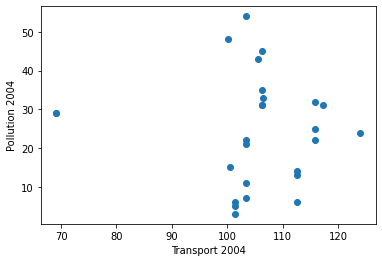

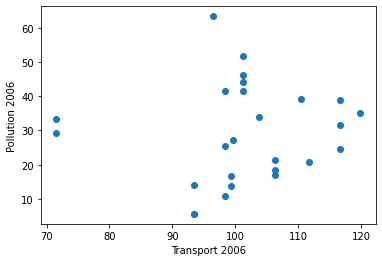

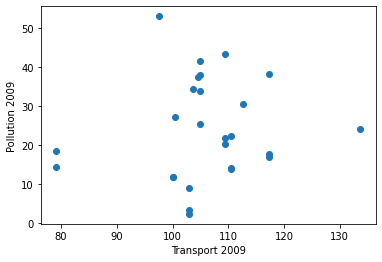

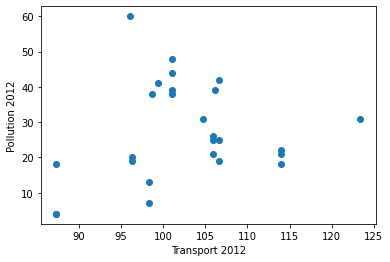

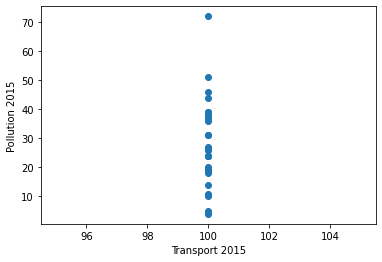

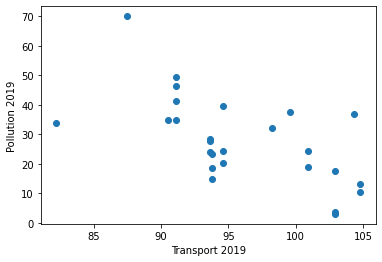

In [327]:
# plot corresponding transport and pollution values through years
for year in ['2004', '2006', '2009', '2012', '2015', '2019']:
    plt.scatter(merged[f'transport_{year}'], merged[f'pollution_{year}'])
    plt.xlabel(f'Transport {year}')
    plt.ylabel(f'Pollution {year}')
    plt.show()



## 6. Predictions

#### 6.1 Create features

In [328]:
# create new features dataframe for ML
columns = ["country", "city", "transport", "pollution", "year"]
features = pd.DataFrame(columns=columns)

# create transport and pollution features based on the transport_YYYY and pollution_YYYY combined
transports = pd.DataFrame()
pollutions = pd.DataFrame()

# extract transport and assign correspoding years
for col in merged.columns:
    if col.startswith('transport_'):
        year = col.split('_')[1]
        polcol = None
        new_rows = merged[[col, 'country', 'city']].rename(columns={col: 'transport'})
        new_rows['year'] = year
        transports = pd.concat([transports, new_rows], ignore_index=True)

# extract pollution and assign corresponding years
for col in merged.columns:
    if col.startswith('pollution_'):
        year = col.split('_')[1]
        polcol = None
        new_rows = merged[[col, 'country', 'city']].rename(columns={col: 'pollution'})
        new_rows['year'] = year
        pollutions = pd.concat([pollutions, new_rows], ignore_index=True)

# merge the transport and pollution into features dataframe
features = pd.merge(transports, pollutions, on=['city', 'year', 'country'],how="left")

# sort by city and year for better view
features = features.sort_values(['city', 'year'])
features = features.reset_index(drop=True)

# reorganize the column names
features = features[['country', 'city', 'transport', 'pollution', 'year']]

# save the features to csv
features.to_csv("features.csv")

# print result
print(features)


    country    city  transport  pollution  year
0        AT  AT001C      100.2       48.0  2004
1        AT  AT001C       96.4       63.4  2006
2        AT  AT001C       97.5       53.1  2009
3        AT  AT001C       96.1       60.0  2012
4        AT  AT001C      100.0       72.0  2015
..      ...     ...        ...        ...   ...
177      UK  UK004C      112.6       30.5  2009
178      UK  UK004C      106.1       39.0  2012
179      UK  UK004C      100.0       39.0  2015
180      UK  UK004C      104.3       36.7  2019
181      UK  UK004C        NaN        NaN  2021

[182 rows x 5 columns]


#### 6.2 Transform features

In [329]:

# work on copy
features_transformed = features.copy()

# years saved here
saved_years = pollution_year_col_names

# encode the year
year_encoder = LabelEncoder()
features_transformed['year'] = year_encoder.fit_transform(features_transformed['year'])

# encode the transport
transport_encoder = MinMaxScaler()
features_transformed[['transport']] = transport_encoder.fit_transform(features_transformed[['transport']])

# encode the pollution
pollution_encoder = MinMaxScaler()
features_transformed[['pollution']] = pollution_encoder.fit_transform(features_transformed[['pollution']])

# add previous values features
features_transformed['transport_prev'] = features_transformed.groupby(['country', 'city'])['transport'].shift()
features_transformed['pollution_prev'] = features_transformed.groupby(['country', 'city'])['pollution'].shift()

# remove the year 0 because it has no previous
features_transformed = features_transformed[features_transformed['year'] != 0]

# fill the one NaN value with a constant because it was sad and lonely
features_transformed['transport'].fillna(0.57, inplace=True)

# save to csv
features_transformed.to_csv("features_transformed.csv")

# show results
print(features_transformed)

# bring back
#features['year'] = year_encoder.inverse_transform(features['year'])
#print(features)



    country    city  transport  pollution  year  transport_prev  \
1        AT  AT001C   0.451471   0.876614     1        0.507353   
2        AT  AT001C   0.467647   0.728838     2        0.451471   
3        AT  AT001C   0.447059   0.827834     3        0.467647   
4        AT  AT001C   0.504412   1.000000     4        0.447059   
5        AT  AT001C   0.320588   0.971306     5        0.504412   
..      ...     ...        ...        ...   ...             ...   
177      UK  UK004C   0.689706   0.404591     2        0.658824   
178      UK  UK004C   0.594118   0.526542     3        0.689706   
179      UK  UK004C   0.504412   0.526542     4        0.594118   
180      UK  UK004C   0.567647   0.493544     5        0.504412   
181      UK  UK004C   0.570000        NaN     6        0.567647   

     pollution_prev  
1          0.655667  
2          0.876614  
3          0.728838  
4          0.827834  
5          1.000000  
..              ...  
177        0.529412  
178        0.404591

#### 6.3 Split

In [330]:
# split the train and predict data based on whether the pollution value is NaN
train_data = features_transformed[~features_transformed['pollution'].isna()]
predict_data = features_transformed[features_transformed['pollution'].isna()]

# data for model training
train_X = train_data[['transport', 'year', 'transport_prev', 'pollution_prev']]
train_Y = train_data['pollution']

# data for making predictions
predict_X = predict_data[['transport', 'year', 'transport_prev', 'pollution_prev']]
predict_Y = predict_data['pollution']

#### 6.4 Training model

In [331]:
# fit the model
model = LinearRegression()
model.fit(train_X, train_Y)

LinearRegression()

#### 6.5 Making predictions

In [332]:
# make predictions
predictions = model.predict(predict_X)

# put answers back into the dataframe
predict_data.loc[:, 'pollution'] = predictions
features_transformed.loc[predict_data.index, 'pollution'] = predictions

# save only answers
predict_data.to_csv("predictions.csv")

# bring back the original encoding
features_transformed['year'] = year_encoder.inverse_transform(features_transformed['year'])
features_transformed[['pollution']] = pollution_encoder.inverse_transform(features_transformed[['pollution']])
features_transformed[['pollution_prev']] = pollution_encoder.inverse_transform(features_transformed[['pollution_prev']])
features_transformed[['transport']] = transport_encoder.inverse_transform(features_transformed[['transport']])
features_transformed[['transport_prev']] = transport_encoder.inverse_transform(features_transformed[['transport_prev']])

# save answers with the rest of the data
features_transformed.to_csv("predictions_full.csv")

#print result
print(features_transformed)

    country    city  transport  pollution  year  transport_prev  \
1        AT  AT001C      96.40  63.400000  2006           100.2   
2        AT  AT001C      97.50  53.100000  2009            96.4   
3        AT  AT001C      96.10  60.000000  2012            97.5   
4        AT  AT001C     100.00  72.000000  2015            96.1   
5        AT  AT001C      87.50  70.000000  2019           100.0   
..      ...     ...        ...        ...   ...             ...   
177      UK  UK004C     112.60  30.500000  2009           110.5   
178      UK  UK004C     106.10  39.000000  2012           112.6   
179      UK  UK004C     100.00  39.000000  2015           106.1   
180      UK  UK004C     104.30  36.700000  2019           100.0   
181      UK  UK004C     104.46  34.548501  2021           104.3   

     pollution_prev  
1              48.0  
2              63.4  
3              53.1  
4              60.0  
5              72.0  
..              ...  
177            39.2  
178            30.5

C:\Users\Filip\AppData\Local\Temp/ipykernel_16908/3878718012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data.loc[:, 'pollution'] = predictions
